In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints
from keras.regularizers import l2
from keras.layers import Dense, Embedding, Input, concatenate, Flatten, Layer
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, Conv1D, MaxPool1D, BatchNormalization
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [30]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
from gensim.models import Word2Vec

In [101]:
import os, re, pickle
import spacy
from spacy.tokens.doc import Doc

### Import Data

In [4]:
train = pd.read_csv('data/labeledTrainData.tsv', sep='\t')
print(train.shape)

(25000, 3)


In [5]:
test = pd.read_csv('data/testData.tsv', sep='\t')
print(test.shape)

(25000, 2)


### Pre-process Data

In [43]:
MAX_FEATURES = 25000
MAX_LEN = 350

In [44]:
list_sentences_train = train['review'].fillna("UNKNOWN").values.tolist()
list_sentences_test = test['review'].fillna("UNKNOWN").values.tolist()

In [45]:
tokenizer = text.Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(list_sentences_train)

In [46]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [47]:
X = sequence.pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
X_test = sequence.pad_sequences(list_tokenized_test, maxlen=MAX_LEN)

In [48]:
y = train['sentiment'].values.reshape(-1,1)

In [23]:
y.shape

(25000,)

In [49]:
N_CLASSES = 1

In [50]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

### Create Model - No External Knowledge

In [85]:
def create_model():
    EMBED_SIZE = 128
    input_sequence = Input(shape=(MAX_LEN, ))
    x = Embedding(input_dim=MAX_FEATURES, output_dim=EMBED_SIZE)(input_sequence)
    x = Dropout(0.1)(x)
    x = Conv1D(filters=64, kernel_size=2, padding='same')(x)
    x = Bidirectional(LSTM(32,
                           return_sequences=True,
                           kernel_regularizer=l2(0.0001)))(x)
    x = GlobalMaxPool1D()(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation="elu", kernel_regularizer=l2(0.0001))(x)
    prediction = Dense(N_CLASSES, activation="sigmoid")(x)
    
    model = Model(inputs=input_sequence, outputs=prediction)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [86]:
model = create_model()

BATCH_SIZE = 512
EPOCHS = 4

In [87]:
FILE_PATH = "models/keras_model_weights.hdf5"
checkpoint = ModelCheckpoint(FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks_list = [checkpoint, early]

In [88]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 350)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 350, 128)          3200000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 350, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 350, 64)           16448     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 350, 64)           24832     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)                256       
__________

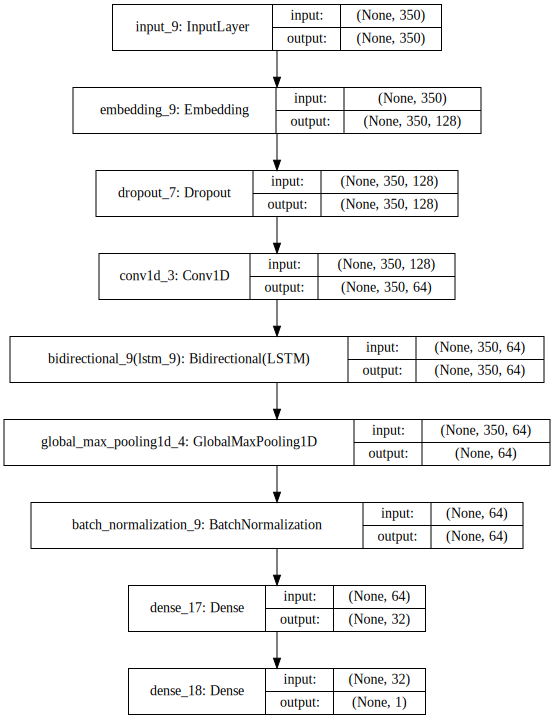

In [89]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [90]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=[X_val, y_val], callbacks=callbacks_list)

Train on 22500 samples, validate on 2500 samples
Epoch 1/4
22016/22500 [============================>.] - ETA: 0s - loss: 0.4677 - acc: 0.7769
Epoch 00001: val_loss improved from inf to 0.29211, saving model to models/keras_model_weights.hdf5
22500/22500 [==============================] - 47s 2ms/step - loss: 0.4642 - acc: 0.7791 - val_loss: 0.2921 - val_acc: 0.8828
Epoch 2/4
22016/22500 [============================>.] - ETA: 0s - loss: 0.1801 - acc: 0.9362
Epoch 00002: val_loss did not improve
22500/22500 [==============================] - 42s 2ms/step - loss: 0.1797 - acc: 0.9363 - val_loss: 0.3848 - val_acc: 0.8436
Epoch 3/4
22016/22500 [============================>.] - ETA: 0s - loss: 0.0683 - acc: 0.9836
Epoch 00003: val_loss did not improve
22500/22500 [==============================] - 42s 2ms/step - loss: 0.0686 - acc: 0.9834 - val_loss: 0.2938 - val_acc: 0.8912
Epoch 4/4
22016/22500 [============================>.] - ETA: 0s - loss: 0.0263 - acc: 0.9964
Epoch 00004: val_loss

In [91]:
model = load_model(filepath=FILE_PATH)

In [92]:
y_val_hat = model.predict(X_val)

In [93]:
print(accuracy_score(y_val, y_val_hat > 0.5))
print(confusion_matrix(y_val, y_val_hat > 0.5))
print(classification_report(y_val, y_val_hat > 0.5))

0.8828
[[1022  206]
 [  87 1185]]
             precision    recall  f1-score   support

          0       0.92      0.83      0.87      1228
          1       0.85      0.93      0.89      1272

avg / total       0.89      0.88      0.88      2500



Useful tutorials:
* http://konukoii.com/blog/2018/02/19/twitter-sentiment-analysis-using-combined-lstm-cnn-models/

### Create Model - Use Pretrained Embeddings, PoS Parsing

#### Prep Data

In [139]:
MAX_FEATURES = 65000
MAX_LEN = 350

In [99]:
list_sentences_train = train['review'].fillna("UNKNOWN").values.tolist()
list_sentences_test = test['review'].fillna("UNKNOWN").values.tolist()

In [100]:
list_sentences_train_parsed = [transform_doc(x, MAX_LEN=1000) for x in list_sentences_train]
list_sentences_test_parsed = [transform_doc(x, MAX_LEN=1000) for x in list_sentences_test]

In [102]:
with open('data/list_sentences_train_parsed.pkl', 'wb') as f:
    pickle.dump(list_sentences_train_parsed, f)
    
with open('data/list_sentences_test_parsed.pkl', 'wb') as f:
    pickle.dump(list_sentences_test_parsed, f)

In [140]:
tokenizer = text.Tokenizer(num_words=MAX_FEATURES, filters='!"#$%&()*+,-/:;<=>?@[\\]^`{}~\t\n', lower=False)
tokenizer.fit_on_texts(list_sentences_train_parsed)

In [141]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train_parsed)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test_parsed)

In [142]:
X_train = sequence.pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
X_test = sequence.pad_sequences(list_tokenized_test, maxlen=MAX_LEN)

In [154]:
y = train['sentiment'].values.reshape(-1,1)

In [155]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

#### Inspect

In [143]:
list_sentences_train_parsed[0]

"With|ADP all_this_stuff|NOUN going|VERB down|PART at|ADP the_moment|NOUN with|ADP MJ|ENT i|PRON 've|VERB started|VERB listening|VERB to|ADP his_music|NOUN ,|PUNCT watching|VERB the_odd_documentary|NOUN here|ADV and|CCONJ there|ADV ,|PUNCT watched|VERB The_Wiz|PROPN and|CCONJ watched|VERB Moonwalker|ENT again|ADV .|PUNCT Maybe|ADV i|PRON just|ADV want|VERB to|PART get|VERB a_certain_insight|NOUN into|ADP this_guy|NOUN who|NOUN i|PRON thought|VERB was|VERB really|ADV cool|ADJ in|ADP the_eighties|DATE just|ADV to|PART maybe|ADV make|VERB up|PART my_mind|NOUN whether|ADP he|PRON is|VERB guilty|ADJ or|CCONJ innocent|ADJ .|PUNCT Moonwalker|ENT is|VERB part_biography|NOUN ,|PUNCT part_feature_film|NOUN which|ADJ i|PRON remember|VERB going|VERB to|PART see|VERB at|ADP the_cinema|NOUN when|ADV it|PRON was|VERB originally|ADV released|VERB .|PUNCT Some|DET of|ADP it|PRON has|VERB subtle_messages|NOUN about|ADP MJ's_feeling|NOUN towards|ADP the_press|NOUN and|CCONJ also|ADV the_obvious_message|N

In [144]:
list_tokenized_train[0]

[427,
 137,
 214,
 33,
 1728,
 13,
 10013,
 117,
 123,
 441,
 1956,
 12,
 9053,
 1,
 130,
 122,
 3,
 47,
 1,
 220,
 3,
 220,
 14945,
 151,
 2,
 550,
 117,
 44,
 147,
 6,
 73,
 72,
 1979,
 29,
 117,
 174,
 10,
 61,
 829,
 7,
 7258,
 44,
 6,
 353,
 87,
 59,
 1491,
 562,
 26,
 5,
 3109,
 38,
 2622,
 2,
 14945,
 5,
 1,
 52,
 117,
 302,
 137,
 6,
 58,
 33,
 1580,
 50,
 9,
 10,
 1306,
 460,
 2,
 699,
 4,
 9,
 36,
 53886,
 42,
 660,
 10795,
 3,
 88,
 4,
 1441,
 20,
 39,
 83,
 6477,
 1249,
 16,
 4,
 305,
 35,
 5,
 78,
 42,
 5265,
 279,
 729,
 19,
 1810,
 41,
 10013,
 7,
 783,
 96,
 19,
 20,
 137,
 6,
 610,
 35,
 3,
 134,
 9,
 418,
 2,
 699,
 164,
 579,
 10013,
 339,
 14,
 36321,
 12,
 3538,
 4,
 48,
 3169,
 10013,
 3,
 241,
 4,
 11248,
 45,
 113,
 18,
 26,
 85,
 9,
 14,
 4242,
 52,
 56,
 468,
 5,
 61,
 628,
 4,
 1528,
 455,
 11,
 390,
 8037,
 7622,
 199,
 257,
 50,
 9,
 377,
 391,
 5,
 106,
 22,
 14,
 7814,
 38,
 46,
 18037,
 3,
 15867,
 5,
 1046,
 15,
 2,
 402,
 26,
 357,
 10013,
 598,
 46,
 

In [145]:
index_word_dict = {v:k for k, v in tokenizer.word_index.items()}
word_index_dict = tokenizer.word_index

In [146]:
for w in list_tokenized_train[0]:
    print(index_word_dict[w])

With|ADP
going|VERB
down|PART
at|ADP
the_moment|NOUN
with|ADP
MJ|ENT
i|PRON
've|VERB
started|VERB
listening|VERB
to|ADP
his_music|NOUN
|PUNCT
watching|VERB
here|ADV
and|CCONJ
there|ADV
|PUNCT
watched|VERB
and|CCONJ
watched|VERB
Moonwalker|ENT
again|ADV
.|PUNCT
Maybe|ADV
i|PRON
just|ADV
want|VERB
to|PART
get|VERB
into|ADP
this_guy|NOUN
who|NOUN
i|PRON
thought|VERB
was|VERB
really|ADV
cool|ADJ
in|ADP
the_eighties|DATE
just|ADV
to|PART
maybe|ADV
make|VERB
up|PART
my_mind|NOUN
whether|ADP
he|PRON
is|VERB
guilty|ADJ
or|CCONJ
innocent|ADJ
.|PUNCT
Moonwalker|ENT
is|VERB
|PUNCT
which|ADJ
i|PRON
remember|VERB
going|VERB
to|PART
see|VERB
at|ADP
the_cinema|NOUN
when|ADV
it|PRON
was|VERB
originally|ADV
released|VERB
.|PUNCT
Some|DET
of|ADP
it|PRON
has|VERB
subtle_messages|NOUN
about|ADP
towards|ADP
the_press|NOUN
and|CCONJ
also|ADV
of|ADP
drugs|NOUN
are|VERB
br|NOUN
br|SYM
Visually|ADV
impressive|ADJ
but|CCONJ
of|ADP
course|NOUN
this|DET
is|VERB
all|DET
about|ADP
Michael_Jackson|ENT
so|ADP
unless|

#### Create Embedding Matrix
(or load one if you have it)

In [109]:
w2v_model = Word2Vec.load('models/w2v_model_128')

In [185]:
EMBED_SIZE = w2v_model.vector_size
print('The size of the gensim word2vec vocab is: {}'.format(len(w2v_model.wv.vocab.items())))

unknown_word_count = 0
def choose_embedded_vector(word, unknown_word_count, verbose=False):
    if word in w2v_model.wv.vocab:
        return w2v_model.wv.word_vec(word), unknown_word_count
    else:
        if verbose:
            print('Unknown word: {}'.format(word))
        return np.random.rand(EMBED_SIZE), (unknown_word_count+1)

index_word_dict = {v:k for k, v in tokenizer.word_index.items()}
word_index_dict = tokenizer.word_index
num_words = tokenizer.num_words + 1 
print('The size of the keras token vocab is: {}'.format(len(index_word_dict)))
print('The tokenizer vocab is limited to: {}'.format(tokenizer.num_words))


embedding_weights = np.zeros((num_words, EMBED_SIZE))
for word, index in word_index_dict.items():
    if index < num_words:
        embedding_weights[index,:], unknown_word_count = choose_embedded_vector(word, unknown_word_count)

print('Total amount of words not found in gensim word2vec model: {}'.format(unknown_word_count))
print('Embedding matrix shape: {}'.format(embedding_weights.shape))

The size of the gensim word2vec vocab is: 67600
The size of the keras token vocab is: 515041
The tokenizer vocab is limited to: 65000
Total amount of words not found in gensim word2vec model: 9831
Embedding matrix shape: (65001, 128)


#### Train Model

In [171]:
def create_model():
    input_sequence = Input(shape=(MAX_LEN, ))
    x = Embedding(input_dim=num_words, output_dim=EMBED_SIZE, input_length=MAX_LEN, mask_zero=False, weights=[embedding_weights], trainable=True)(input_sequence)
    x = Dropout(0.1)(x)
    x = Conv1D(filters=64, kernel_size=2, padding='same')(x)
    x = Bidirectional(LSTM(32,
                           return_sequences=True,
                           kernel_regularizer=l2(0.0001)))(x)
    x = AttentionWithContext()(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation="elu", kernel_regularizer=l2(0.0001))(x)
    prediction = Dense(N_CLASSES, activation="sigmoid")(x)
    
    model = Model(inputs=input_sequence, outputs=prediction)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [172]:
model = create_model()

BATCH_SIZE = 512
EPOCHS = 16

In [173]:
FILE_PATH = "models/keras_model_weights.hdf5"
checkpoint = ModelCheckpoint(FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks_list = [checkpoint, early]

In [174]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 350)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 350, 128)          8320128   
_________________________________________________________________
dropout_10 (Dropout)         (None, 350, 128)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 350, 64)           16448     
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 350, 64)           24832     
_________________________________________________________________
attention_with_context_1 (At (None, 64)                4224      
_________________________________________________________________
batch_normalization_12 (Batc (None, 64)                256       
__________

In [175]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=[X_val, y_val], callbacks=callbacks_list)

Train on 22500 samples, validate on 2500 samples
Epoch 1/16
22016/22500 [============================>.] - ETA: 0s - loss: 0.5839 - acc: 0.6969
Epoch 00001: val_loss improved from inf to 0.47400, saving model to models/keras_model_weights.hdf5
22500/22500 [==============================] - 42s 2ms/step - loss: 0.5825 - acc: 0.6980 - val_loss: 0.4740 - val_acc: 0.7844
Epoch 2/16
22016/22500 [============================>.] - ETA: 0s - loss: 0.4274 - acc: 0.8093
Epoch 00002: val_loss improved from 0.47400 to 0.38924, saving model to models/keras_model_weights.hdf5
22500/22500 [==============================] - 38s 2ms/step - loss: 0.4263 - acc: 0.8095 - val_loss: 0.3892 - val_acc: 0.8276
Epoch 3/16
22016/22500 [============================>.] - ETA: 0s - loss: 0.3479 - acc: 0.8547
Epoch 00003: val_loss improved from 0.38924 to 0.35733, saving model to models/keras_model_weights.hdf5
22500/22500 [==============================] - 39s 2ms/step - loss: 0.3475 - acc: 0.8550 - val_loss: 0.357

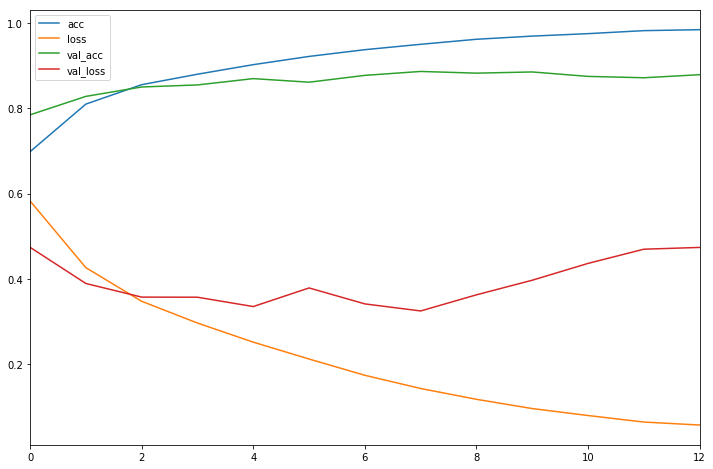

In [176]:
pd.DataFrame(model.history.history).plot(figsize=(12,8))

In [177]:
model = load_model(filepath=FILE_PATH, custom_objects={'AttentionWithContext':AttentionWithContext})

In [178]:
y_hat = model.predict(X_val)

In [181]:
print(accuracy_score(y_val, y_hat > 0.5))
print(confusion_matrix(y_val, y_hat > 0.5))
print(classification_report(y_val, y_hat > 0.5))

0.886
[[1069  159]
 [ 126 1146]]
             precision    recall  f1-score   support

          0       0.89      0.87      0.88      1228
          1       0.88      0.90      0.89      1272

avg / total       0.89      0.89      0.89      2500



### Helper Functions

A lot of the spacy code was pulled from examples: https://github.com/explosion

In [97]:
nlp = spacy.load('en_core_web_sm')

LABELS = {
    'ENT': 'ENT',
    'PERSON': 'ENT',
    'NORP': 'ENT',
    'FAC': 'ENT',
    'ORG': 'ENT',
    'GPE': 'ENT',
    'LOC': 'ENT',
    'LAW': 'ENT',
    'PRODUCT': 'ENT',
    'EVENT': 'ENT',
    'WORK_OF_ART': 'ENT',
    'LANGUAGE': 'ENT',
    'DATE': 'DATE',
    'TIME': 'TIME',
    'PERCENT': 'PERCENT',
    'MONEY': 'MONEY',
    'QUANTITY': 'QUANTITY',
    'ORDINAL': 'ORDINAL',
    'CARDINAL': 'CARDINAL'
}


pre_format_re = re.compile(r'^[\`\*\~]')
post_format_re = re.compile(r'[\`\*\~]$')
url_re = re.compile(r'\[([^]]+)\]\(%%URL\)')
link_re = re.compile(r'\[([^]]+)\]\(https?://[^\)]+\)')


def strip_meta(text):
    if type(text) == str:
        text = link_re.sub(r'\1', text)
        text = text.replace('&gt;', '>').replace('&lt;', '<')
        text = pre_format_re.sub('', text)
        text = post_format_re.sub('', text)
        return text
    else:
        return ''
    

def represent_word(word):
    if word.like_url:
        return '%%URL|X'
    text = re.sub(r'\s', '_', word.text)
    tag = LABELS.get(word.ent_type_, word.pos_)
    if not tag:
        tag = '?'
    return text + '|' + tag


def merge_clean_sentence(nlp, text, collapse_punctuation=True, collapse_phrases=True):
    doc = nlp(text)
    if collapse_punctuation:
        spans = []
        for word in doc[:-1]:
            if word.is_punct:
                continue
            if not word.nbor(1).is_punct:
                continue
            start = word.i
            end = word.i + 1
            while end < len(doc) and doc[end].is_punct:
                end += 1
            span = doc[start : end]
            spans.append(
                (span.start_char, span.end_char,
                 {'tag': word.tag_, 'lemma': word.lemma_, 'ent_type': word.ent_type_})
            )
        for start, end, attrs in spans:
            doc.merge(start, end, **attrs)

    if collapse_phrases:
        for np in list(doc.noun_chunks):
            np.merge(tag=np.root.tag_, lemma=np.root.lemma_, ent_type=np.root.ent_type_)
    
    return doc


def transform_doc(text, MAX_LEN):
    d = merge_clean_sentence(nlp, text, collapse_punctuation=False, collapse_phrases=True)
    strings = []
    for sent in d.sents:
        if sent.text.strip():
            for w in sent:
                if not w.is_space:
                    strings.append(represent_word(w))
    if strings:
        return ' '.join(strings[0:MAX_LEN])
    else:
        return ' '.join(['' for x in range(MAX_LEN)])

Attention adapted from: https://gist.github.com/cbaziotis/6428df359af27d58078ca5ed9792bd6d

In [96]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.

    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.

    Note: The layer has been tested with Keras 2.0.6

    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]